In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from glob import glob

from sys import path
path.insert(0, "lib")
from colorline import colorline
from SGD_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer, ExponentialConvectionTerm

from fipy.tools import numerix

# Steady state linear model

In [11]:
def get_SGD_data_lin(std_epsilon, lr, b):
    """
    For SGD data with linear potential, 
    autocorrelation time is short enough that simulating one SGD trajectory is sufficient to approximate the trajectory distribution
    """
    
    def q(w):
        return w-.5
    
    def grad_q(w):
        return 1.

    w_init = .1
    seed = 42
    nsamp = 10**5
    nsteps = 10**5
    S = SGD(std_epsilon, lr, q, grad_q, w_init, nsamp, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [14]:
def get_approxSGD_data_lin(std_epsilon, lr, b):
    """
    For SGD data with linear potential, 
    autocorrelation time is short enough that simulating one SGD trajectory is sufficient to approximate the trajectory distribution
    """
    
    def q(w):
        return w-.5
    
    def grad_q(w):
        return 1.

    w_init = .1
    seed = 42
    nsteps = 10**5
    S = ApproxSGD(std_epsilon, lr, q, grad_q, w_init, b, seed)
    S.evolve(nsteps)
    return np.array(S.w)

In [12]:
stde = 1.
lr = 0.01
b = 10
ws = get_SGD_data_lin(stde, lr, b)

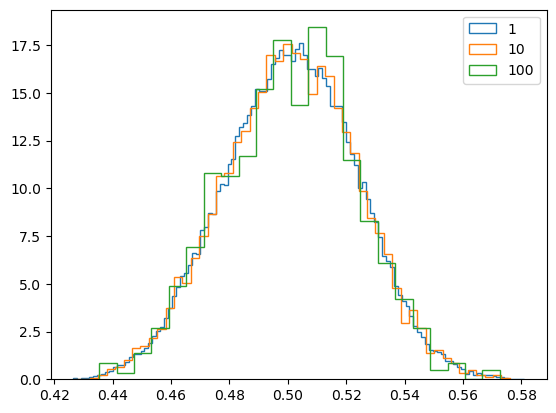

In [13]:
# histograms for different autocorrelation times
ti = 10**3
for tc in [1, 10, 100]:
    data = ws[ti::tc]
    plt.hist(data, bins='auto', histtype='step', label=f'{tc}', density=True)
plt.legend()
plt.show()

In [23]:
approxws = get_approxSGD_data_lin(stde, lr, b)

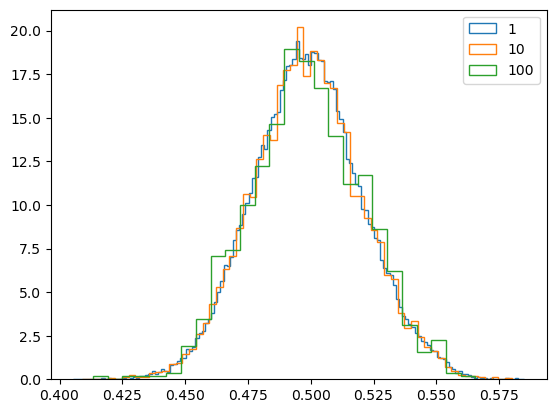

In [24]:
# histograms for different autocorrelation times
ti = 10**3
for tc in [1, 10, 100]:
    data = approxws[ti::tc]
    plt.hist(data, bins='auto', histtype='step', label=f'{tc}', density=True)
plt.legend()
plt.show()

# Linear model

In [65]:
def q(w):
    return (w-.5)*(w*w+1)

def grad_q(w):
    return w*w+1 + 2*w*(w-.5)

std_epsilon = 1.2
lr = .01
nsamp = 10**5
batchsize = 20
nseed = 4*10**4
nsteps = 10
filename = 'data/nonlin_'
for seed in range(3*nseed, 4*nseed):
    state = np.random.RandomState(seed=seed)
    w_init = state.uniform(0, 1)
    save_data(std_epsilon, lr, q, grad_q, w_init, nsamp, batchsize, seed, nsteps, filename)

In [66]:
stdes = [1.2]
data = []
for stde in stdes:
    files = glob(f'data/nonlin_stde{stde}*.dat')
    print(len(files))
    data.append(np.array([np.loadtxt(file) for file in files]))

80000


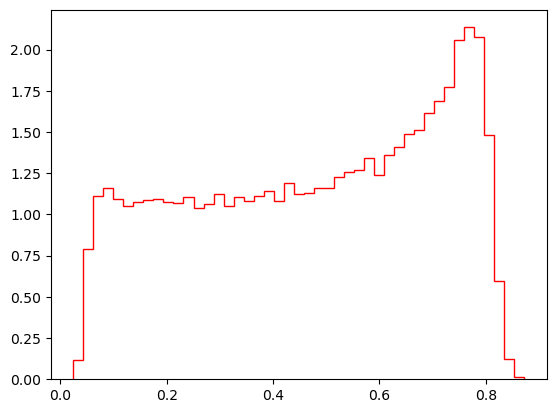

In [67]:
for ste, cdat, color in zip(stdes, data, ['r', 'b']):
    plt.hist(cdat.T[-1], color=color, histtype='step', density=True, bins='auto')
plt.savefig('data.png', dpi=150)
plt.show()

# Singular double-well model

In [121]:
a = 1.97

def q(w):
    return (w-1.)*(w-2*a-1.)**2.
    
def grad_q(w):
    return (w-2*a-1.)**2. + 2.*(w-1.)*(w-2*a-1.)

lr = .01
nsamp = 10**6
batchsize = 100
nsteps = 10**4
filename = f'data/double_a{a}_'
nseed = 10**4
for seed in range(0, nseed):
    state = np.random.RandomState(seed=seed)
    w_init = state.uniform(0, 2*a + 2)
    save_data(lr, q, grad_q, w_init, nsamp, batchsize, seed, nsteps, filename)

/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_19723/552242242.py:4: RuntimeWarning: overflow encountered in scalar power
  return (w-1.)*(w-2*a-1.)**2.
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_19723/552242242.py:7: RuntimeWarning: overflow encountered in scalar power
  return (w-2*a-1.)**2. + 2.*(w-1.)*(w-2*a-1.)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_19723/552242242.py:7: RuntimeWarning: overflow encountered in scalar multiply
  return (w-2*a-1.)**2. + 2.*(w-1.)*(w-2*a-1.)
/var/folders/lb/0wvyvp693x9fpgwng1wv1hwc0000gn/T/ipykernel_19723/552242242.py:4: RuntimeWarning: overflow encountered in scalar multiply
  return (w-1.)*(w-2*a-1.)**2.


In [33]:
a = 1.97
files = glob(f'data/double_a{a}_*.dat')
data = np.array([np.loadtxt(file) for file in files])

In [34]:
files[0]

'data/double_a1.97_lr0.01_winit_2.7159388356290832_nsamp1000000_b100_seed6458_nsteps10000.dat'

In [35]:
data.shape

(10000, 10001)

In [36]:
np.savetxt('data/double_a1.97_lr0.01_nsamp1000000_b100_nsteps10000.dat', data)

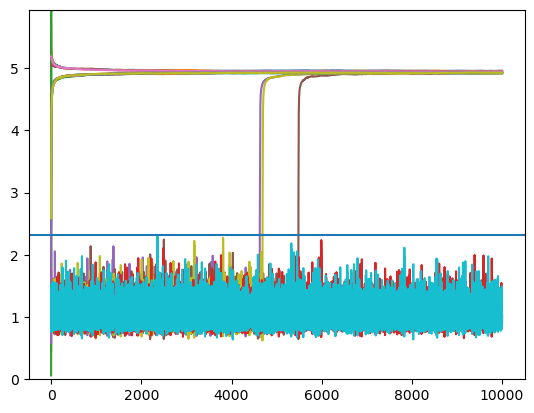

In [120]:
plt.plot(data.T)
plt.ylim(0, 2*a+2)
plt.axhline(y=(2 + 2*a + 1)/3)
plt.savefig('data.png', dpi=150)
plt.show()

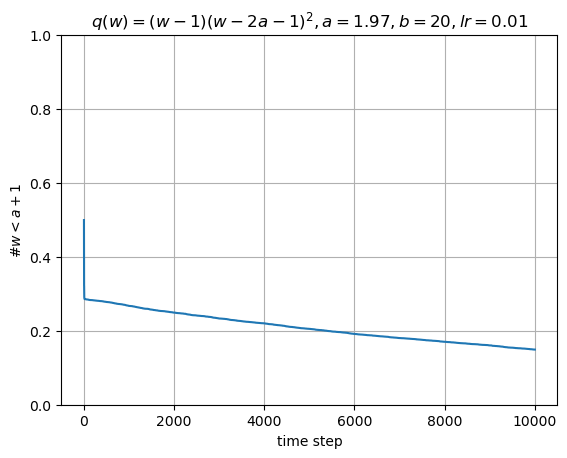

In [37]:
reg = np.mean(data < a + 1., axis = 0)
sing = np.mean(data > a + 1., axis = 0)
plt.plot(reg)
plt.grid()
plt.ylim(0,1)
plt.xlabel('time step')
plt.ylabel('$\# w < a + 1$')
plt.title(f'$q(w)=(w-1)(w-2a-1)^2, a={a}, b={batchsize}, lr={lr}$')
plt.savefig('escape.png', dpi=150)
plt.show()